# Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

def explore_sales_data(df, date_from_cols=True):
    """
    Generate a wide range of plots to understand weekly sales data for forecasting.

    Parameters:
    - df: pandas DataFrame with expected columns
    - date_from_cols: if True, create 'Date' column using Year + Week
    """
    if date_from_cols:
        df['Date'] = pd.to_datetime(df['Year'].astype(str) + df['Week'].astype(str).str.zfill(2) + '1', format='%G%V%u')

    # 1. Time Plot
    plt.figure(figsize=(12, 5))
    df.groupby('Date')['Rolling_Mean_2_Weeks'].sum().plot()
    plt.title('Total 2-Week Rolling Sales Over Time')
    plt.ylabel('Sales')
    plt.grid()
    plt.show()

    # 2. Seasonal Box Plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Week', y='Rolling_Mean_2_Weeks', data=df)
    plt.title('Seasonal Pattern: Sales by Week Number')
    plt.xticks(rotation=90)
    plt.show()

    # 3. Seasonal Subseries Plot
    plt.figure(figsize=(14, 6))
    sns.lineplot(x='Week', y='Rolling_Mean_2_Weeks', hue='Year', data=df, palette='tab10')
    plt.title('Sales Seasonality (Week vs Year)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # 4. Lag Plot
    lag_plot(df['Rolling_Mean_2_Weeks'])
    plt.title('Lag Plot: Rolling Sales')
    plt.show()

    # 5. Autocorrelation
    autocorrelation_plot(df['Rolling_Mean_2_Weeks'])
    plt.title('Autocorrelation Plot of Sales')
    plt.show()

    # 6. Correlation Heatmap
    plt.figure(figsize=(12, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # 7. Scatter Plot: Size vs Sales by Type
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Size', y='Rolling_Mean_2_Weeks', hue='Type', data=df)
    plt.title('Store Size vs Sales by Store Type')
    plt.show()

    # 8. Pairplot
    sns.pairplot(df[['Size', 'Fuel_Price', 'CPI', 'Unemployment', 'Rolling_Mean_2_Weeks']])
    plt.show()

    # 9. Sample Store Sales Trends
    sample_stores = df['Store'].unique()[:5]
    plt.figure(figsize=(12, 6))
    for store in sample_stores:
        subset = df[df['Store'] == store].sort_values('Date')
        plt.plot(subset['Date'], subset['Rolling_Mean_2_Weeks'], label=f'Store {store}')
    plt.legend()
    plt.title('Sales Trend per Sample Store')
    plt.show()

    # 10. Decomposition Plot (store=0)
    # store_df = df[df['Store'] == 0].sort_values('Date').set_index('Date')
    # ts = store_df['Rolling_Mean_2_Weeks'].fillna(method='ffill')  # fill forward

    # result = seasonal_decompose(ts, model='additive', period=52)
    # result.plot()
    # plt.suptitle("Decomposition of Sales - Store 0")
    # plt.show()


    # 11. Missing Values Heatmap
    pivot = df.pivot_table(index='Week', columns='Year', values='Rolling_Mean_2_Weeks')
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot.isna(), cbar=False, cmap='gray')
    plt.title('Missing Data Pattern (Week vs Year)')
    plt.show()

    # 12. Sales Distribution by Store Type
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Type', y='Rolling_Mean_2_Weeks', data=df)
    plt.title('Sales Distribution by Store Type')
    plt.show()

    # 13. Holiday Sales Impact
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='IsHoliday', y='Rolling_Mean_2_Weeks', data=df)
    plt.title('Sales on Holidays vs Non-Holidays')
    plt.xticks([0, 1], ['No Holiday', 'Holiday'])
    plt.show()

    # 14. Weekly Sales Heatmap by Store
    heat_df = df.pivot_table(index='Week', columns='Store', values='Rolling_Mean_2_Weeks')
    plt.figure(figsize=(16, 8))
    sns.heatmap(heat_df, cmap='YlGnBu')
    plt.title('Sales Heatmap (Week vs Store)')
    plt.show()

# Preprocess

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy import stats

def pre_process():
    data = pd.read_csv('train.csv')
    stores = pd.read_csv('stores.csv')
    features = pd.read_csv('features.csv')

    features['CPI'] = features['CPI'].fillna(features['CPI'].median())
    features['Unemployment'] = features['Unemployment'].fillna(features['Unemployment'].median())
    for i in range(1, 6):
        features[f'MarkDown{i}'] = features[f'MarkDown{i}'].apply(lambda x: 0 if x < 0 else x).fillna(0)

    data = pd.merge(data, stores, on='Store', how='left')
    data = pd.merge(data, features, on=['Store', 'Date'], how='left')

    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data.sort_values(by='Date', inplace=True)
    data.set_index('Date', inplace=True)

    data.drop(columns='IsHoliday_x', inplace=True)
    data.rename(columns={'IsHoliday_y': 'IsHoliday'}, inplace=True)

    agg = data.groupby(['Store', 'Dept']).Weekly_Sales.agg(['max', 'min', 'mean', 'median', 'std']).reset_index()
    data = pd.merge(data.reset_index(), agg, on=['Store', 'Dept'], how='left')

    data['Total_MarkDown'] = sum([data[f'MarkDown{i}'] for i in range(1, 6)])
    data.drop([f'MarkDown{i}' for i in range(1, 6)], axis=1, inplace=True)

    numeric_col = ['Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Total_MarkDown']
    data_numeric = data[numeric_col].copy()
    data = data[(np.abs(stats.zscore(data_numeric)) < 2.5).all(axis=1)]
    data = data[data['Weekly_Sales'] >= 0]
    data['IsHoliday'] = data['IsHoliday'].astype(int)

    cat_col = ['Store', 'Dept', 'Type']
    for col in cat_col:
        data[col] = pd.factorize(data[col])[0]

    return data

# Feature Engineering

In [ ]:
# === Feature Engineering ===
def create_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['DayOfWeek'] = df['Date'].dt.dayofweek

    df['Lag_1_Week_Sales'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
    df['Lag_2_Week_Sales'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)
    df['Rolling_Mean_2_Weeks'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=2).mean())
    df['Rolling_Mean_4_Weeks'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=4).mean())

    df['Store_Size_Interaction'] = df['Size'] * df['Weekly_Sales']
    df['Size_x_Fuel'] = df['Size'] * df['Fuel_Price']
    df['CPI_x_Unemp'] = df['CPI'] * df['Unemployment']
    df['Fuel_Price_sq'] = df['Fuel_Price']**2

    df.dropna(inplace=True)
    return df

# Process Data

In [ ]:
# === Data Preparation ===
def get_data(lstm_cols, mlp_cols):
    data = pre_process()
    data = create_features(data)

    X = data.drop(['Weekly_Sales', 'Date'], axis=1)
    y = data['Weekly_Sales']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0) # shuffle=False
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=0) # shuffle=False

    lstm_scaler = MinMaxScaler()
    mlp_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    # lstm_scaler = StandardScaler()
    # mlp_scaler = StandardScaler()
    # target_scaler = StandardScaler()

    lstm_scaler.fit(X_train[lstm_cols])
    mlp_scaler.fit(X_train[mlp_cols])

    for df in [X_train, X_valid, X_test]:
        df[lstm_cols] = lstm_scaler.transform(df[lstm_cols])
        df[mlp_cols] = mlp_scaler.transform(df[mlp_cols])

    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_valid = target_scaler.transform(y_valid.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

    for df in [X_train, X_valid, X_test]:
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(0, inplace=True)

    y_train = np.nan_to_num(y_train)
    y_valid = np.nan_to_num(y_valid)
    y_test = np.nan_to_num(y_test)

    return X_train, X_valid, X_test, y_train, y_valid, y_test, target_scaler

# Hybrid Model

In [ ]:
# === Dataset & Model ===
class HybridDataset(Dataset):
    def __init__(self, X, y, lstm_cols, mlp_cols):
        self.lstm_data = torch.tensor(X[lstm_cols].values, dtype=torch.float32).unsqueeze(1)
        self.mlp_data = torch.tensor(X[mlp_cols].values, dtype=torch.float32)
        self.targets = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self): return len(self.targets)
    def __getitem__(self, idx): return self.lstm_data[idx], self.mlp_data[idx], self.targets[idx]

class HybridLSTMMLP(nn.Module):
    def __init__(self, lstm_input_size, lstm_hidden_size, lstm_num_layers,
                 mlp_input_size, mlp_hidden_sizes, output_dim, dropout_p=0.2, bidirectional=True):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
            dropout=dropout_p if lstm_num_layers > 1 else 0,
            bidirectional=bidirectional
        )

        lstm_out_dim = lstm_hidden_size * (2 if bidirectional else 1)
        self.lstm_norm = nn.LayerNorm(lstm_out_dim)
        self.attention = nn.Sequential(
            nn.Linear(lstm_out_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )

        mlp_layers = []
        prev_size = mlp_input_size
        for hidden_size in mlp_hidden_sizes:
            mlp_layers.append(nn.Linear(prev_size, hidden_size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.BatchNorm1d(hidden_size))
            mlp_layers.append(nn.Dropout(dropout_p))
            prev_size = hidden_size
        self.mlp = nn.Sequential(*mlp_layers)

        self.final = nn.Linear(lstm_out_dim + prev_size, output_dim)

    def forward(self, lstm_input, mlp_input):
        if lstm_input.dim() == 2:
            lstm_input = lstm_input.unsqueeze(1)

        lstm_out, _ = self.lstm(lstm_input)  # shape: (B, T, H)
        attn_weights = self.attention(lstm_out)  # shape: (B, T, 1)
        attn_applied = torch.sum(attn_weights * lstm_out, dim=1)  # (B, H)

        lstm_feat = self.lstm_norm(attn_applied)
        mlp_feat = self.mlp(mlp_input)

        combined = torch.cat((lstm_feat, mlp_feat), dim=1)
        return self.final(combined)

# Training

In [ ]:
# === Training & Evaluation ===
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for lstm, mlp, target in loader:
        lstm, mlp, target = lstm.to(device), mlp.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(lstm, mlp)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(target)
    return total_loss / len(loader.dataset)

# Validation

In [ ]:
def validate(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for lstm, mlp, target in loader:
            lstm, mlp, target = lstm.to(device), mlp.to(device), target.to(device)
            output = model(lstm, mlp)
            loss = loss_fn(output, target)
            total_loss += loss.item() * len(target)
    return total_loss / len(loader.dataset)

# Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model = None

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1
        return self.counter >= self.patience

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=100):
    early_stop = EarlyStopping(patience=5)
    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss = validate(model, val_loader, loss_fn, device)
        # print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.8f} | Val Loss: {val_loss:.8f}")

        if early_stop(model, val_loss):
            print("Early stopping!")
            model.load_state_dict(early_stop.best_model)
            break

# Evaluation

In [ ]:
# this is working, next cell is just trial to see if that approach is proper and better
# def evaluate(model, loader, device, scaler_y, n_bootstraps=1000, mape_threshold=0.1):
#     model.eval()
#     preds, actuals = [], []

#     with torch.no_grad():
#         for lstm, mlp, target in loader:
#             lstm, mlp = lstm.to(device), mlp.to(device)
#             output = model(lstm, mlp).cpu().numpy()
#             target = target.cpu().numpy()

#             preds.extend(scaler_y.inverse_transform(output).flatten())
#             actuals.extend(scaler_y.inverse_transform(target).flatten())

#     preds = np.array(preds)
#     actuals = np.array(actuals)

#     # plot actual vs predicted
#     plt.plot(actuals[:100], label='Actual')
#     plt.plot(preds[:100], label='Predicted')
#     plt.legend()
#     plt.show()
#     ######################################

#     valid_mask = actuals > mape_threshold
#     filtered_actuals = actuals[valid_mask]
#     filtered_preds = preds[valid_mask]

#     mse = mean_squared_error(actuals, preds)
#     rmse = root_mean_squared_error(actuals, preds)
#     mae = mean_absolute_error(actuals, preds)
#     mape = mean_absolute_percentage_error(filtered_actuals, filtered_preds) * 100
#     r2 = r2_score(actuals, preds)

#     n = len(actuals)
#     mse_list, rmse_list, mae_list, mape_list = [], [], [], []
#     for _ in range(n_bootstraps): # <<< To Do: this bootstrap is 1000, adjust this approach, seems wrong laa... :)
#         idx = np.random.choice(n, n, replace=True)
#         sa, sp = actuals[idx], preds[idx]
#         err = sp - sa
#         mse_list.append(np.mean(err ** 2))
#         rmse_list.append(np.sqrt(np.mean(err ** 2)))
#         mae_list.append(np.mean(np.abs(err)))

#         sa_filtered = sa[sa > mape_threshold]
#         sp_filtered = sp[sa > mape_threshold]
#         if len(sa_filtered) > 0:
#             mape_list.append(mean_absolute_percentage_error(sa_filtered, sp_filtered) * 100)

#     print("\n📊 Final Test Results:")
#     print(f"  MSE: {mse:.2f} ± {np.std(mse_list, ddof=1):.2f}")
#     print(f"  RMSE: {rmse:.2f} ± {np.std(rmse_list, ddof=1):.2f}")
#     print(f"  MAE: {mae:.2f} ± {np.std(mae_list, ddof=1):.2f}")
#     print(f"  MAPE: {mape:.2f}% ± {np.std(mape_list, ddof=1):.2f}%")

#     print(f"  R²: {r2:.4f}")

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, r2_score
)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate(model, loader, device, scaler_y, n_bootstraps=None):
    model.eval()
    preds, actuals = [], []

    with torch.no_grad():
        for lstm, mlp, target in loader:
            lstm, mlp = lstm.to(device), mlp.to(device)
            output = model(lstm, mlp).cpu().numpy()
            target = target.cpu().numpy()

            preds.extend(scaler_y.inverse_transform(output).flatten())
            actuals.extend(scaler_y.inverse_transform(target).flatten())

    preds = np.array(preds)
    actuals = np.array(actuals)

    # Metrics
    mse = mean_squared_error(actuals, preds)
    rmse = root_mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)
    # mape = mean_absolute_percentage_error(actuals, preds) * 100
    # Instead of filtering by threshold manually, we’ll mask zero/near-zero actuals
    safe_mask = actuals != 0
    filtered_actuals = actuals[safe_mask]
    filtered_preds = preds[safe_mask]

    # MAPE on real values
    mape = mean_absolute_percentage_error(filtered_actuals, filtered_preds) * 100


    r2 = r2_score(actuals, preds)

    # Bootstrapping (adaptive number of samples if not provided)
    n = len(actuals)
    if n_bootstraps is None:
        n_bootstraps = min(1000, max(100, n // 10))

    mse_list, rmse_list, mae_list, mape_list = [], [], [], []
    r2_boot = []
    for _ in range(n_bootstraps):
        idx = np.random.choice(n, n, replace=True)
        sa, sp = actuals[idx], preds[idx]
        err = sp - sa
        mse_list.append(np.mean(err ** 2))
        rmse_list.append(np.sqrt(np.mean(err ** 2)))
        mae_list.append(np.mean(np.abs(err)))
        # mape_list.append(mean_absolute_percentage_error(sa, sp) * 100)
        # MAPE: exclude zero targets
        safe_mask = sa != 0
        sa_filtered = sa[safe_mask]
        sp_filtered = sp[safe_mask]
        if len(sa_filtered) > 0:
          mape_list.append(mean_absolute_percentage_error(sa_filtered, sp_filtered) * 100)

        r2_boot.append(r2_score(actuals[idx], preds[idx]))
    r2_std = np.std(r2_boot, ddof=1)

    # Results
    # print("\n📊 Final Test Results:")
    # print(f"  MSE: {mse:.4f} ± {np.std(mse_list, ddof=1):.4f}")
    # print(f"  RMSE: {rmse:.4f} ± {np.std(rmse_list, ddof=1):.4f}")
    # print(f"  MAE: {mae:.4f} ± {np.std(mae_list, ddof=1):.4f}")
    # print(f"  MAPE: {mape:.2f}% ± {np.std(mape_list, ddof=1):.2f}%")
    # print(f"  R²: {r2:.4f}")

    print("\n📊 Final Test Results:")
    print(f"  MSE: {mse:.2f} ± {np.std(mse_list, ddof=1):.2f}")
    print(f"  RMSE: {rmse:.2f} ± {np.std(rmse_list, ddof=1):.2f}")
    print(f"  MAE: {mae:.2f} ± {np.std(mae_list, ddof=1):.2f}")
    print(f"  MAPE: {mape:.2f} ± {np.std(mape_list, ddof=1):.2f}")
    print(f"  R²: {r2:.4f} ± {r2_std:.4f}")

    # Partial prediction plot (first 100)
    plt.figure(figsize=(10, 4))
    plt.plot(actuals[:100], label='Actual')
    plt.plot(preds[:100], label='Predicted')
    plt.title("First 100 Samples - Actual vs Predicted")
    plt.xlabel("Sample")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # Full comparison plot
    plt.figure(figsize=(14, 5))
    plt.plot(actuals, label='Actual', alpha=0.7)
    plt.plot(preds, label='Predicted', alpha=0.7)
    plt.title("Full Prediction vs Actual")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Scatter plot: Predicted vs Actual
    plt.figure(figsize=(6, 6))
    plt.scatter(actuals, preds, color='gold', edgecolor='black', alpha=0.7, label="Predicted vs. Actual Values")

    # Perfect prediction line
    min_val = min(np.min(actuals), np.min(preds))
    max_val = max(np.max(actuals), np.max(preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'b--', label="Perfect Prediction")

    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual Scatter Plot")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ------------------------------------------
    # Calculate absolute errors
    abs_errors = np.abs(actuals - preds)

    # Get indices of top N biggest errors
    N = 20  # you can adjust this
    top_idx = np.argsort(-abs_errors)[:N]

    # Plot actual vs predicted for top-N biggest errors
    plt.figure(figsize=(12, 6))
    x = np.arange(N)
    width = 0.35

    plt.bar(x - width/2, actuals[top_idx], width, label='Actual', color='skyblue')
    plt.bar(x + width/2, preds[top_idx], width, label='Predicted', color='salmon')
    plt.xticks(x, [f"#{i}" for i in top_idx], rotation=45)
    plt.ylabel("Value")
    plt.title(f"Top {N} Largest Prediction Errors")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Show Data

In [ ]:
lstm_cols = [
    'IsHoliday', 'Year', 'Month', 'Week', 'DayOfWeek',
    'Lag_1_Week_Sales', 'Lag_2_Week_Sales', 'Rolling_Mean_2_Weeks', 'Rolling_Mean_4_Weeks',
]
mlp_cols = [
    'Store', 'Dept', 'Type', 'Size',
    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'min', 'max', 'mean', 'median', 'std',
    'Total_MarkDown', 'Store_Size_Interaction',
    'Size_x_Fuel', 'CPI_x_Unemp', 'Fuel_Price_sq'
]
X_train, X_valid, X_test, y_train, y_valid, y_test, target_scaler = get_data(lstm_cols, mlp_cols)
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
print(X_train.describe())
print(X_train.head())
print(X_valid.head())
print(X_test.head())
print(y_train)
print(y_test)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
               Store           Dept           Type           Size  \
count  247916.000000  247916.000000  247916.000000  247916.000000   
mean        0.474860       0.440456       0.297450       0.540359   
std         0.282949       0.265767       0.330547       0.328853   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.227273       0.212500       0.000000       0.315637   
50%         0.477273       0.437500       0.000000       0.504647   
75%         0.727273       0.662500       0.500000       0.906277   
max         1.000000       1.000000       1.000000       1.000000   

         Temperature     Fuel_Price            CPI   Unemployment  \
count  247916.000000  247916.000000  247916.000000  247916.000000   
mean        0.543784       0.438467       0.468865       0.457241   
std         0.206593       0.235315       0.384877       0.166742   
min         0.000000       0.000000       0.

# Main Execution

Epoch   1 | Train Loss: 0.01721506 | Val Loss: 0.00115280
Epoch   2 | Train Loss: 0.00181029 | Val Loss: 0.00056285
Epoch   3 | Train Loss: 0.00065248 | Val Loss: 0.00017003
Epoch   4 | Train Loss: 0.00034206 | Val Loss: 0.00007148
Epoch   5 | Train Loss: 0.00023645 | Val Loss: 0.00005788
Epoch   6 | Train Loss: 0.00019252 | Val Loss: 0.00002589
Epoch   7 | Train Loss: 0.00016139 | Val Loss: 0.00002009
Epoch   8 | Train Loss: 0.00014264 | Val Loss: 0.00001901
Epoch   9 | Train Loss: 0.00012960 | Val Loss: 0.00000962
Epoch  10 | Train Loss: 0.00011544 | Val Loss: 0.00000584
Epoch  11 | Train Loss: 0.00010661 | Val Loss: 0.00001584
Epoch  12 | Train Loss: 0.00010114 | Val Loss: 0.00000883
Epoch  13 | Train Loss: 0.00009439 | Val Loss: 0.00005902
Epoch  14 | Train Loss: 0.00008942 | Val Loss: 0.00000580
Epoch  15 | Train Loss: 0.00008468 | Val Loss: 0.00000352
Epoch  16 | Train Loss: 0.00007859 | Val Loss: 0.00000923
Epoch  17 | Train Loss: 0.00007653 | Val Loss: 0.00000266
Epoch  18 | Tr

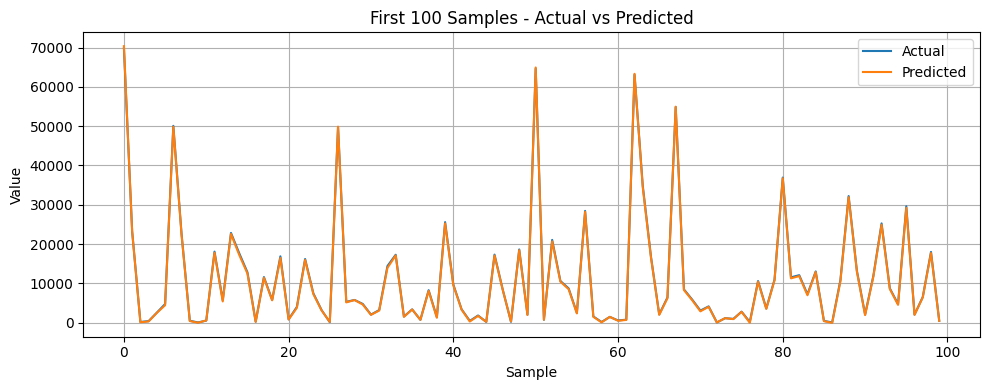

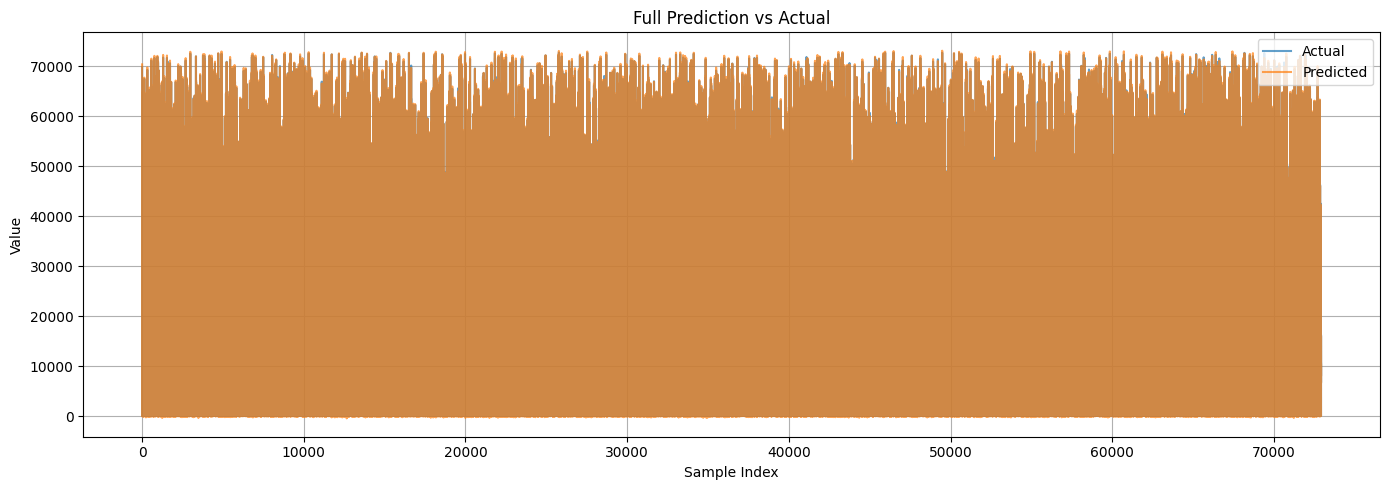

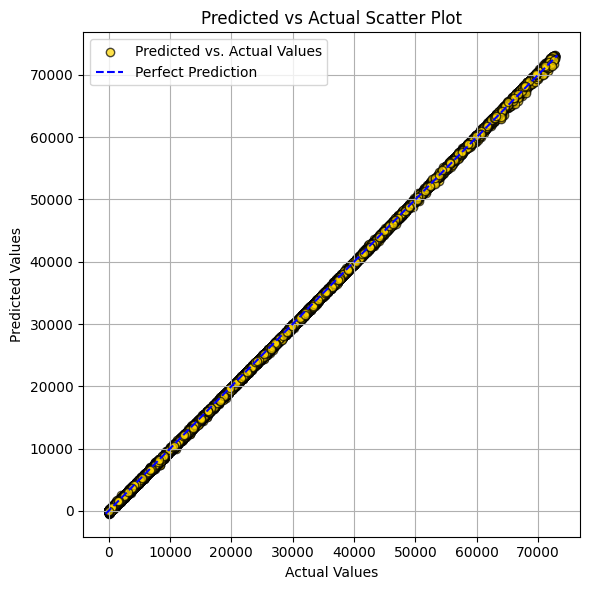

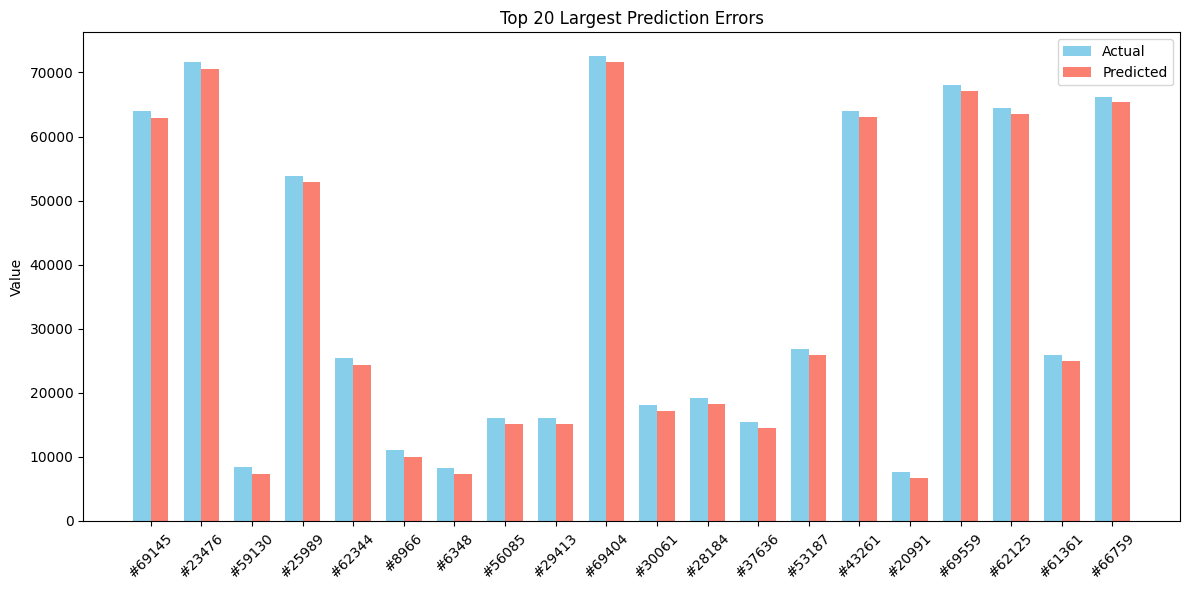

In [ ]:
train_dataset = HybridDataset(X_train, y_train, lstm_cols, mlp_cols)
val_dataset = HybridDataset(X_valid, y_valid, lstm_cols, mlp_cols)
test_dataset = HybridDataset(X_test, y_test, lstm_cols, mlp_cols)

# https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
# train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True) # main reference source code set this to True
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = HybridLSTMMLP(len(lstm_cols), 64, 2, len(mlp_cols), [64, 32], 1).to(device)
# model = HybridLSTMMLP(len(lstm_cols), 64, 2, len(mlp_cols), [128, 64, 32], 1).to(device)
model = HybridLSTMMLP(
    lstm_input_size=len(lstm_cols),
    lstm_hidden_size=64,
    lstm_num_layers=2,
    mlp_input_size=len(mlp_cols),
    # mlp_hidden_sizes=[128, 64, 32],
    mlp_hidden_sizes=[256, 128, 64, 32],
    output_dim=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=100)
evaluate(model, test_loader, device, target_scaler)

Hasil

In [ ]:
#    Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
# 0 2010-02-05      0     0      24924.50     0  151315        42.31
# 1 2010-02-05      1     1      15552.08     1   93638        24.36
# 2 2010-02-05      1     2       3200.22     1   93638        24.36
# 3 2010-02-05      1     3      10820.05     1   93638        24.36
# 4 2010-02-05      1     4      20055.64     1   93638        24.36

#    Fuel_Price         CPI  Unemployment  IsHoliday       max       min  \
# 0       2.572  211.096358         8.106          0  57592.12  14537.37
# 1       2.788  131.527903        10.064          0  69467.35   6642.10
# 2       2.788  131.527903        10.064          0  26440.84    805.79
# 3       2.788  131.527903        10.064          0  99680.98   5642.05
# 4       2.788  131.527903        10.064          0  28478.15  16859.93

#            mean    median           std  Total_MarkDown
# 0  22513.322937  18535.48   9854.349032             0.0
# 1  12931.821259  10898.36   8868.631880             0.0
# 2   3289.884965   2684.12   3058.515710             0.0
# 3  16854.082238  13066.83  12955.930323             0.0
# 4  20680.465944  20490.17   1618.396782             0.0
# Epoch 0: Train Loss = 0.0738, Val Loss = 0.0120
# Epoch 1: Train Loss = 0.0477, Val Loss = 0.0381
# Epoch 2: Train Loss = 0.0435, Val Loss = 0.0060
# Epoch 3: Train Loss = 0.0420, Val Loss = 0.0030
# Epoch 4: Train Loss = 0.0404, Val Loss = 0.0327
# Epoch 5: Train Loss = 0.0380, Val Loss = 0.0063
# Epoch 6: Train Loss = 0.0367, Val Loss = 0.0142
# Epoch 7: Train Loss = 0.0373, Val Loss = 0.0056
# Epoch 8: Train Loss = 0.0368, Val Loss = 0.0061
# Early stopping.
# >>>>> preds[0] 19321.016
# >>>>> actuals[0] 19274.34
# >>>>> errors[0] 46.67578

# 📊 Final Test Results:
#   MSE: 715162.81 ± 12634.34
#   RMSE: 845.67 ± 2.33
#   MAE: 555.25 ± 2.33
#   MAPE: 1036.02% ± 25408.36%
#   R²: 0.9970

In [ ]:
# Epoch 0: Train Loss = 0.1372, Val Loss = 0.0829
# Epoch 1: Train Loss = 0.1163, Val Loss = 0.0891
# Epoch 2: Train Loss = 0.1129, Val Loss = 0.0732
# Epoch 3: Train Loss = 0.1086, Val Loss = 0.0718
# Epoch 4: Train Loss = 0.1068, Val Loss = 0.0700
# Epoch 5: Train Loss = 0.1057, Val Loss = 0.0713
# Epoch 6: Train Loss = 0.1040, Val Loss = 0.0682
# Epoch 7: Train Loss = 0.1024, Val Loss = 0.0721
# Epoch 8: Train Loss = 0.1028, Val Loss = 0.0695
# Epoch 9: Train Loss = 0.1010, Val Loss = 0.0680
# Epoch 10: Train Loss = 0.1013, Val Loss = 0.0692
# Epoch 11: Train Loss = 0.1003, Val Loss = 0.0693
# Epoch 12: Train Loss = 0.1006, Val Loss = 0.0698
# Epoch 13: Train Loss = 0.0994, Val Loss = 0.0734
# Epoch 14: Train Loss = 0.0996, Val Loss = 0.0675
# Epoch 15: Train Loss = 0.0986, Val Loss = 0.0705
# Epoch 16: Train Loss = 0.0977, Val Loss = 0.0687
# Epoch 17: Train Loss = 0.0981, Val Loss = 0.0720
# Epoch 18: Train Loss = 0.0986, Val Loss = 0.0739
# Epoch 19: Train Loss = 0.0988, Val Loss = 0.0661
# Epoch 20: Train Loss = 0.0985, Val Loss = 0.0767
# Epoch 21: Train Loss = 0.0978, Val Loss = 0.0707
# Epoch 22: Train Loss = 0.0982, Val Loss = 0.0687
# Epoch 23: Train Loss = 0.0967, Val Loss = 0.0715
# Epoch 24: Train Loss = 0.0971, Val Loss = 0.0668
# Early stopping.

# 📊 Final Test Results (in thousands $):
#   MSE: 16.41 ± 93.15
#   RMSE: 4.05 ± 3.50
#   MAE: 2.04 ± 3.50
#   MAPE: 31.94% ± 126.87% # Note: ubah STD report nya (margin of error nya jangan percentage: 126.87%, benchmark aja gada persennya)
#   R²: 0.9303 # Note: ini masih bisa di improve kah?

In [ ]:
# Epoch 0: Train Loss = 0.1379, Val Loss = 0.0791
# Epoch 1: Train Loss = 0.1174, Val Loss = 0.1040
# Epoch 2: Train Loss = 0.1124, Val Loss = 0.0708
# Epoch 3: Train Loss = 0.1081, Val Loss = 0.0761
# Epoch 4: Train Loss = 0.1069, Val Loss = 0.0931
# Epoch 5: Train Loss = 0.1042, Val Loss = 0.0818
# Epoch 6: Train Loss = 0.1038, Val Loss = 0.0703
# Epoch 7: Train Loss = 0.1032, Val Loss = 0.0721
# Epoch 8: Train Loss = 0.1017, Val Loss = 0.0704
# Epoch 9: Train Loss = 0.1025, Val Loss = 0.0724
# Epoch 10: Train Loss = 0.1018, Val Loss = 0.0693
# Epoch 11: Train Loss = 0.0997, Val Loss = 0.0737
# Epoch 12: Train Loss = 0.0995, Val Loss = 0.0683
# Epoch 13: Train Loss = 0.0998, Val Loss = 0.0720
# Epoch 14: Train Loss = 0.0986, Val Loss = 0.0681
# Epoch 15: Train Loss = 0.0990, Val Loss = 0.0690
# Epoch 16: Train Loss = 0.0984, Val Loss = 0.0777
# Epoch 17: Train Loss = 0.0972, Val Loss = 0.0754
# Epoch 18: Train Loss = 0.0967, Val Loss = 0.0710
# Epoch 19: Train Loss = 0.0968, Val Loss = 0.0727
# Early stopping.

# 📊 Final Test Results (in thousands $):
#   MSE: 16.77 ± 96.42
#   RMSE: 4.09 ± 3.51
#   MAE: 2.10 ± 3.51
#   MAPE: 47.14% ± 155.30%
#   R²: 0.9287
